In [4]:
!wget https://www.nuscenes.org/data/v1.0-mini.tgz  # Download the nuScenes mini split.

!tar -xf v1.0-mini.tgz -C ./data/sets/nuscenes  # Uncompress the nuScenes mini split.

!pip install nuscenes-devkit &> /dev/null  # Install nuScenes.

In [26]:
from nuscenes.nuscenes import NuScenes
import matplotlib.pyplot as plt
import cv2
import os
import matplotlib.patches as patches

In [27]:
data_path = './data/sets/nuscenes'
nusc = NuScenes(version='v1.0-mini', dataroot='./data/sets/nuscenes', verbose=True)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.385 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


usando o yolo

In [25]:
!pip install ultralytics #ultralytics que mantem o yolov8

# Sprint 3
1 - Transformar as boxes 3d no nuscenes em 2d\
2 - Aprender a trabalhar com objetos de forma isolada\
3 - Treinar o yolo de forma customizada

In [28]:
from get_2D_boxes_from_sample_data import get_2D_boxes_from_sample_data
import json

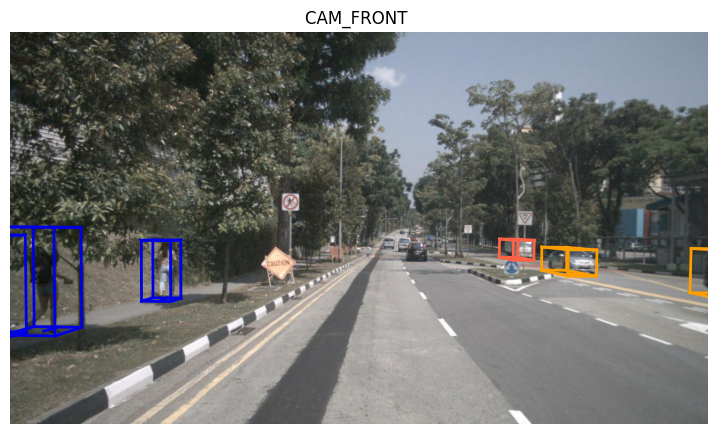

In [29]:
# Exemplo será dado no primeiro frame da cena 5
cena = nusc.scene[5]
sample = nusc.get('sample', cena['first_sample_token'])
sample_data = nusc.get('sample_data', sample['data']['CAM_FRONT'])
nusc.render_sample_data(sample_data['token'])

In [30]:
# Função que recebe o token da cena e retorna as bounding boxes 2D com anotações
from nuscenes.utils.geometry_utils import BoxVisibility

def get_boxes_from_specified_frame(nusc, frame_token):
    
    sample = nusc.get('sample', frame_token) # Obter o sample específico pelo token de frame fornecido
    
    sample_data = nusc.get('sample_data', sample['data']['CAM_FRONT']) # Trocar para outros sensores aqui quando necessário
        
    # Chamar a função para obter as bounding boxes 2D
    boxes_anns = get_2D_boxes_from_sample_data(nusc, sample_data['token'], box_vis_level=BoxVisibility.ANY, visibilities=['1', '2', '3', '4'])
    
    return boxes_anns


In [31]:
# Plotar as bounding boxes e anotações
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_boxes_on_image(image_path, boxes, annotations):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Criar uma figura e um eixo para plotar
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(img)
    
    # Plotar cada bounding box com sua anotação
    for box, label in zip(boxes, annotations):
        # Extrair coordenadas e dimensões da bounding box
        x_min, y_min, x_max, y_max = box
        width, height = x_max - x_min, y_max - y_min
        
        # Criar um retângulo para a bounding box
        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='yellow', facecolor='none')
        ax.add_patch(rect)
        
        # Adicionar a etiqueta/label da bounding box
        ax.text(x_min, y_min, label, color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))
    
    plt.show()

In [32]:
# Inicializar o dicionário que armazenará os dados por cena
scenes_data = {}

for i in range(10): # Iterar sobre a qtd de cenas total
    scene = nusc.scene[i]
    scene_token = scene['token']  # Obter o token da cena atual
    frame_token = nusc.get('sample', scene['first_sample_token'])

    # Inicializar a lista que conterá os dados de todos os frames desta cena
    frames = []

    while frame_token['next'] != '':
        frame_token = nusc.get('sample', frame_token['next'])
        boxes, anns = get_boxes_from_specified_frame(nusc, frame_token['token'])
        image_path = data_path + '/' + nusc.get('sample_data', frame_token['data']['CAM_FRONT'])['filename']

        # Adicionar informações do frame na lista de frames
        frames.append({'boxes': boxes, 'anns': anns, 'path': image_path})

    # Atribuir a lista de frames à cena correspondente no dicionário
    scenes_data[scene_token] = frames

# Agora, scenes_data contém um dicionário onde cada chave é um token de cena,
# e o valor é uma lista de dicionários com dados dos frames.

print(json.dumps(scenes_data, indent=4))


{
    "cc8c0bf57f984915a77078b10eb33198": [
        {
            "boxes": [
                [
                    1245.7866892853185,
                    475.34746781138864,
                    1267.3752896978735,
                    514.2613591929758
                ],
                [
                    1565.1104026754142,
                    488.6597179140922,
                    1694.2973419873185,
                    526.4010637661264
                ],
                [
                    1226.7018755315946,
                    475.59000645547866,
                    1273.3620227114468,
                    515.7308819823318
                ],
                [
                    1577.1906198398026,
                    477.48267535657646,
                    1619.9457222671742,
                    548.1815204433902
                ],
                [
                    778.0308304711076,
                    461.2120947464004,
                    795.0517880946078,
         

Para treinar o yolov8 de forma custom, preciso que as anotações estejam no formato:
<object-class> <x_center> <y_center> <width> <height> 
exemplo:
0 0.51171875 0.3984375 0.2421875 0.1953125
1 0.63671875 0.6015625 0.2265625 0.296875

as medidas são normalizados entre 0 e 1 em relação às dimensões da imagem.

In [33]:
def convert_to_yolo_format(boxes, annotations, image_width, image_height, class_mapping):
    yolo_annotations = []

    for box, label in zip(boxes, annotations):
        x_min, y_min, x_max, y_max = box

        # Normalizar as coordenadas
        x_center = (x_min + x_max) / 2.0 / image_width
        y_center = (y_min + y_max) / 2.0 / image_height
        width = (x_max - x_min) / image_width
        height = (y_max - y_min) / image_height

        # Mapear a classe para um índice
        class_id = class_mapping[label]

        # Formato YOLO: <class_id> <x_center> <y_center> <width> <height>
        yolo_annotations.append(f"{class_id} {x_center} {y_center} {width} {height}")

    return yolo_annotations


In [34]:
def getNuscClasses(): 
    category_names = {cat['token']: cat['name'] for cat in nusc.category}
    classes = {}
    i = 0
    for cat_token, cat_name in category_names.items():
        classes[cat_name] = i
        i += 1
    return classes


In [35]:
# Inserindo os dados YOLO formatados no dicionário de frames
class_mapping = getNuscClasses()

for scene_token in scenes_data:
    frames = scenes_data[scene_token]  # Lista de frames para a cena atual
    for frame in frames:
        # Obter a largura e altura da imagem
        img = cv2.imread(frame['path'])
        img_height, img_width, _ = img.shape

        # Converter as boxes e anotações para o formato YOLO
        yolo_formatted_annotations = convert_to_yolo_format(frame['boxes'], frame['anns'], img_width, img_height, class_mapping)

        # Adicionar as anotações YOLO formatadas ao dicionário do frame
        frame['yolo_anns'] = yolo_formatted_annotations

        # Imprimir as anotações YOLO para verificar
        # print("\nYOLO formatted annotations for frame: ", frame['path'], "in scene: ", scene_token)
        # for annotation in yolo_formatted_annotations:
        #     print(annotation)


print(scenes_data)

{'cc8c0bf57f984915a77078b10eb33198': [{'boxes': [(1245.7866892853185, 475.34746781138864, 1267.3752896978735, 514.2613591929758), (1565.1104026754142, 488.6597179140922, 1694.2973419873185, 526.4010637661264), (1226.7018755315946, 475.59000645547866, 1273.3620227114468, 515.7308819823318), (1577.1906198398026, 477.48267535657646, 1619.9457222671742, 548.1815204433902), (778.0308304711076, 461.2120947464004, 795.0517880946078, 497.89553257692756), (691.9907985307514, 467.2883776765617, 712.186120264203, 505.16438428579295), (1271.9772390067585, 502.4480693723626, 1357.3036887315434, 581.4717048033152), (1238.0467400340822, 500.72142008555466, 1315.0447546886933, 571.0993991738932), (1034.668746089555, 469.4960365224752, 1129.2981400764827, 543.1676918123081), (1253.2520159984251, 478.3723419481723, 1278.0726656381973, 518.1694237622283), (-578.2813013349312, -38.94452824500709, 570.6019589187357, 844.8151952372851), (637.3313702985795, 451.0659965126782, 729.9389645284167, 491.649242775

em scenes_data, as coordenadas das boxes estão no formato x_center y_center width height

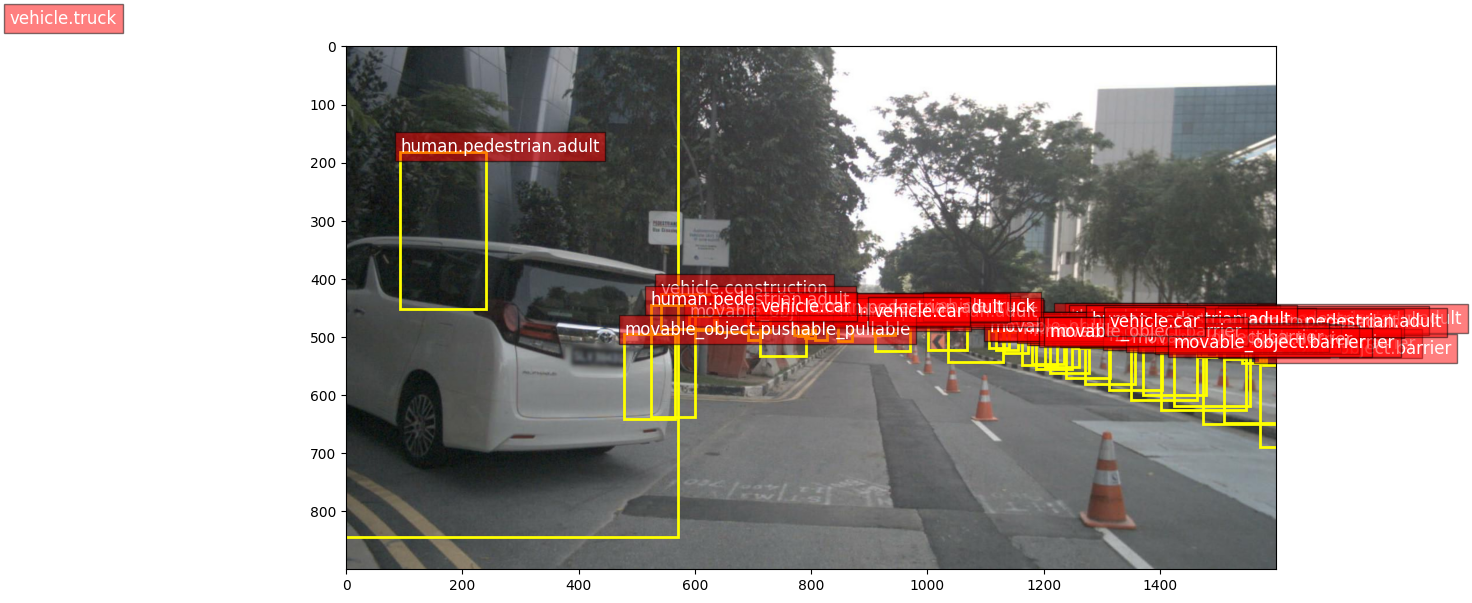

In [36]:
scenes_data['cc8c0bf57f984915a77078b10eb33198'][1]['path'] # primeiro o token da cena, depois o numero do frame, depois o atributo desejado
first_scene = scenes_data['cc8c0bf57f984915a77078b10eb33198']
plot_boxes_on_image(first_scene[35]['path'], first_scene[0]['boxes'], first_scene[0]['anns'])


Treinando o modelo de forma personalizada


In [37]:
from nuscenes.utils.splits import create_splits_scenes

splits = create_splits_scenes()

train_scenes = splits['mini_train']
val_scenes = splits['mini_val']

print("scene: ", scene)

print("Train scenes: ", train_scenes)
print("Validation scenes: ", val_scenes)
# token = nusc.field2token('scene', 'name', scene)[0]
# print("Token: ", token)
  




scene:  {'token': 'e233467e827140efa4b42d2b4c435855', 'log_token': '8fefc430cbfa4c2191978c0df302eb98', 'nbr_samples': 40, 'first_sample_token': 'a480496a5988410fbe3d8ed6c84da996', 'last_sample_token': 'abf3d91d3c28407e80e3334fe89c03cb', 'name': 'scene-1100', 'description': 'Night, peds in sidewalk, peds cross crosswalk, scooter, PMD, difficult lighting'}
Train scenes:  ['scene-0061', 'scene-0553', 'scene-0655', 'scene-0757', 'scene-0796', 'scene-1077', 'scene-1094', 'scene-1100']
Validation scenes:  ['scene-0103', 'scene-0916']


In [38]:
import os
import shutil
import cv2

def setup_yolo_training_environment(scenes_data, class_mapping, train_scenes, val_scenes):
    base_dir = './custom_train'
    train_image_dir = os.path.join(base_dir, 'images', 'train')
    train_label_dir = os.path.join(base_dir, 'labels', 'train')
    val_image_dir = os.path.join(base_dir, 'images', 'val')
    val_label_dir = os.path.join(base_dir, 'labels', 'val')

    # Criar diretórios
    os.makedirs(train_image_dir, exist_ok=True)
    os.makedirs(train_label_dir, exist_ok=True)
    os.makedirs(val_image_dir, exist_ok=True)
    os.makedirs(val_label_dir, exist_ok=True)

    # Distribuir imagens e anotações entre treinamento e validação conforme as divisões de cenas
    for scene_token, frames in scenes_data.items():
        scene_name = nusc.get('scene', scene_token)['name']
        if scene_name in train_scenes:
            image_dir, label_dir = train_image_dir, train_label_dir
        elif scene_name in val_scenes:
            image_dir, label_dir = val_image_dir, val_label_dir
        else:
            print(f'Cena {scene_name} não está em train_scenes ou val_scenes')
            continue  # Pular cenas que não estão em train_scenes ou val_scenes

        for frame in frames:
            img_filename = os.path.basename(frame['path'])
            new_image_path = os.path.join(image_dir, img_filename)
            shutil.copy(frame['path'], new_image_path)

            label_filename = img_filename.replace('.jpg', '.txt')
            new_label_path = os.path.join(label_dir, label_filename)
            with open(new_label_path, 'w') as f:
                for annotation in frame['yolo_anns']:
                    f.write(annotation + '\n')

            print(f'Imagem copiada para: {new_image_path}')
            print(f'Anotações salvas em: {new_label_path}')

# Chamar a função de configuração usando as divisões específicas
setup_yolo_training_environment(scenes_data, class_mapping, train_scenes, val_scenes)

# Criar arquivo YAML
data_yaml_content = f"""path: {os.path.abspath('./custom_train')}
train: images/train
val: images/val

nc: {len(class_mapping)}
names: {list(class_mapping.keys())}
"""

yaml_path = './custom_train/data.yaml'
with open(yaml_path, 'w') as yaml_file:
    yaml_file.write(data_yaml_content)

print(f'Arquivo YAML criado em: {yaml_path}')


Imagem copiada para: ./custom_train/images/train/n015-2018-07-24-11-22-45+0800__CAM_FRONT__1532402928112460.jpg
Anotações salvas em: ./custom_train/labels/train/n015-2018-07-24-11-22-45+0800__CAM_FRONT__1532402928112460.txt
Imagem copiada para: ./custom_train/images/train/n015-2018-07-24-11-22-45+0800__CAM_FRONT__1532402928662460.jpg
Anotações salvas em: ./custom_train/labels/train/n015-2018-07-24-11-22-45+0800__CAM_FRONT__1532402928662460.txt
Imagem copiada para: ./custom_train/images/train/n015-2018-07-24-11-22-45+0800__CAM_FRONT__1532402929162460.jpg
Anotações salvas em: ./custom_train/labels/train/n015-2018-07-24-11-22-45+0800__CAM_FRONT__1532402929162460.txt
Imagem copiada para: ./custom_train/images/train/n015-2018-07-24-11-22-45+0800__CAM_FRONT__1532402929662460.jpg
Anotações salvas em: ./custom_train/labels/train/n015-2018-07-24-11-22-45+0800__CAM_FRONT__1532402929662460.txt
Imagem copiada para: ./custom_train/images/train/n015-2018-07-24-11-22-45+0800__CAM_FRONT__1532402930112

In [39]:
# Nova tentativa de treinar o yolo
from IPython import display
display.clear_output() # Limpar a saída para evitar poluição visual

import ultralytics
ultralytics.checks() # Verificar se o ambiente está configurado corretamente

Ultralytics YOLOv8.2.32 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1070, 8192MiB)
Setup complete ✅ (12 CPUs, 15.6 GB RAM, 108.8/1006.9 GB disk)


In [40]:
# Treino do yolo por CLI
# O parametro model pode ser alterado por outros modelos disponivels no ultralytics
# O parametro data é o caminho para o arquivo yaml criado anteriormente
# O parametro epochs é o numero de epocas que o modelo será treinado
# O parametro plots é um booleano que indica se os gráficos de treinamento serão plotados
!yolo task=detect mode=train model=yolov8s.pt data=/home/sprigganunix/Projetos/YOLO/custom_train/data.yaml epochs=100 plots=True optimizer=SGD lr0=0.0001 lrf=0.0001 batch=32 workers=4

New https://pypi.org/project/ultralytics/8.2.42 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.32 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1070, 8192MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/home/sprigganunix/Projetos/YOLO/custom_train/data.yaml, epochs=100, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=4, project=None, name=train35, exist_ok=False, pretrained=True, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina

In [41]:
# Validando o modelo por cli
!yolo task=detect mode=val model=runs/detect/train35/weights/best.pt data=/home/sprigganunix/Projetos/YOLO/custom_train/data.yaml

Ultralytics YOLOv8.2.32 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1070, 8192MiB)
Model summary (fused): 168 layers, 11134485 parameters, 0 gradients, 28.5 GFLOPs
val: Scanning /home/sprigganunix/Projetos/YOLO/custom_train/labels/val.cache... 
val: WARNING ⚠️ /home/sprigganunix/Projetos/YOLO/custom_train/images/val/n008-2018-08-01-15-16-36-0400__CAM_FRONT__1533151605512404.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0247]
val: WARNING ⚠️ /home/sprigganunix/Projetos/YOLO/custom_train/images/val/n008-2018-08-01-15-16-36-0400__CAM_FRONT__1533151606012404.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.3125      1.0039]
val: WARNING ⚠️ /home/sprigganunix/Projetos/YOLO/custom_train/images/val/n008-2018-08-01-15-16-36-0400__CAM_FRONT__1533151607512404.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.8572      3.7161      2.6524]
val: WARNING ⚠️ /home/spri

In [42]:
# Testar o modelo treinado nas imagens de validacao (fica salvo em runs/predict)
!yolo task=detect mode=predict model=runs/detect/train34/weights/best.pt conf=0.25 source=/home/sprigganunix/Projetos/YOLO/custom_train/images/val

Ultralytics YOLOv8.2.32 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1070, 8192MiB)
Model summary (fused): 168 layers, 11134485 parameters, 0 gradients, 28.5 GFLOPs

image 1/79 /home/sprigganunix/Projetos/YOLO/custom_train/images/val/n008-2018-08-01-15-16-36-0400__CAM_FRONT__1533151604012404.jpg: 384x640 14 human.pedestrian.adults, 4 vehicle.cars, 51.4ms
image 2/79 /home/sprigganunix/Projetos/YOLO/custom_train/images/val/n008-2018-08-01-15-16-36-0400__CAM_FRONT__1533151604512404.jpg: 384x640 12 human.pedestrian.adults, 4 vehicle.cars, 1 movable_object.trafficcone, 9.4ms
image 3/79 /home/sprigganunix/Projetos/YOLO/custom_train/images/val/n008-2018-08-01-15-16-36-0400__CAM_FRONT__1533151605012404.jpg: 384x640 12 human.pedestrian.adults, 4 vehicle.cars, 10.2ms
image 4/79 /home/sprigganunix/Projetos/YOLO/custom_train/images/val/n008-2018-08-01-15-16-36-0400__CAM_FRONT__1533151605512404.jpg: 384x640 7 human.pedestrian.adults, 5 vehicle.cars, 10.0ms
image 5/79 /home/spriggan

In [49]:
# Testar o modelo usando o python
from ultralytics import YOLO
from ultralytics.utils.plotting import Annotator

# Carregar o modelo treinado
model = YOLO("runs/detect/train33/weights/best.pt")

# Testar o modelo em uma imagem
results = model(["/home/sprigganunix/Projetos/YOLO/custom_train/images/val/n008-2018-08-01-15-16-36-0400__CAM_FRONT__1533151604012404.jpg"])

for result in results:
    # detection
    result.boxes.xyxy   # box with xyxy format, (N, 4)
    result.boxes.xywh   # box with xywh format, (N, 4)
    result.boxes.xyxyn  # box with xyxy format but normalized, (N, 4)
    result.boxes.xywhn  # box with xywh format but normalized, (N, 4)
    result.boxes.conf   # confidence score, (N, 1)
    result.boxes.cls    # cls, (N, 1)

    print("boxes da imagem: ", result.boxes.xyxy)
    print("confiança: ", result.boxes.conf)






0: 384x640 14 human.pedestrian.adults, 4 vehicle.cars, 10.8ms
Speed: 1.2ms preprocess, 10.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)
boxes da imagem:  tensor([[ 519.2682,  479.0136,  556.0963,  566.6437],
        [1351.8419,  471.1012, 1395.0764,  567.0059],
        [1291.9049,  472.3175, 1334.5166,  567.6942],
        [1007.1414,  479.9487, 1075.9624,  532.9107],
        [1508.5876,  436.2210, 1600.0000,  630.9732],
        [  97.8674,  529.6219,  158.1360,  590.8068],
        [ 184.8697,  500.7501,  218.7816,  569.5453],
        [1363.2627,  471.5936, 1402.7561,  568.2346],
        [ 575.3135,  515.3643,  599.5682,  544.4042],
        [ 938.1198,  465.4859,  986.8806,  504.9705],
        [  87.5460,  529.4232,  160.1918,  614.9161],
        [ 686.5919,  482.5151,  705.3470,  520.5237],
        [ 701.7700,  487.0400,  723.6750,  519.2039],
        [1265.9867,  483.5670, 1299.8704,  545.5437],
        [ 799.5861,  480.6830,  892.8336,  542.4423],
        [126

In [50]:
# Função para extrair as detecções do modelo YOLO (é possivel adicionar também o nivel de confiança no retorno)
def extract_detections(results, model):
    boxes_list = []
    labels_list = []
    
    # Assegura que model.names contém os nomes das classes mapeados pelo índice
    for result in results:
        # Extrair as boxes e a confiança
        boxes = result.boxes.xyxy.cpu().numpy()  # Convertendo para NumPy array e movendo para CPU
        confs = result.boxes.conf.cpu().numpy()
        classes = result.boxes.cls.cpu().numpy()  # Índices das classes

        # Iterar sobre cada box
        for box, conf, cls_idx in zip(boxes, confs, classes):
            x1, y1, x2, y2 = map(float, box) # Convertendo para float (atribuindo somente box originalmente me deu problema por ser float32, json nao aceitou)
            class_name = model.names[int(cls_idx)]  # Convertendo índice para nome da classe
            boxes_list.append((x1, y1, x2, y2))
            labels_list.append(class_name)

    return boxes_list, labels_list # boxes list aqui tem o formato xyxy, o que significa que x1 y1 é o canto superior esquerdo e x2 y2 é o canto inferior direito




In [51]:
json_content = {}
# no json_content deve ter o scene_token como chave, dentro disso uma lista de sample_data_token e dentro de cada um desses uma lista de anotações e boxes do yolo
for scene in val_scenes:
    scene_token = nusc.field2token('scene', 'name', scene)[0] # Buscando o token da cena
    cena = nusc.get('scene', scene_token) # Buscando a cena
    sample = nusc.get('sample', cena['first_sample_token']) # Buscando a primeira amostra da cena
    while sample['next'] != '':
        sample = nusc.get('sample', sample['next'])
        sample_data = nusc.get('sample_data', sample['data']['CAM_FRONT'])
        file = sample_data['filename']
        file = 'custom_train/images/val/' + file.split('/')[2]
        results = model([file]) # Detectando objetos na imagem com o yolo aqui
        boxes, labels = extract_detections(results, model)
        print(boxes)
        json_content[sample_data['token']] = {'boxes': boxes, 'labels': labels}





0: 384x640 14 human.pedestrian.adults, 4 vehicle.cars, 10.1ms
Speed: 1.3ms preprocess, 10.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)
[(519.2682495117188, 479.01361083984375, 556.0962524414062, 566.6437377929688), (1351.8419189453125, 471.1012268066406, 1395.076416015625, 567.0059204101562), (1291.9049072265625, 472.3175048828125, 1334.5166015625, 567.6942138671875), (1007.1414184570312, 479.94866943359375, 1075.96240234375, 532.9107055664062), (1508.587646484375, 436.22100830078125, 1600.0, 630.9732055664062), (97.867431640625, 529.6219482421875, 158.13601684570312, 590.8068237304688), (184.86972045898438, 500.75006103515625, 218.78155517578125, 569.5453491210938), (1363.2626953125, 471.59356689453125, 1402.756103515625, 568.234619140625), (575.3134765625, 515.3643188476562, 599.5682373046875, 544.4042358398438), (938.1197509765625, 465.48590087890625, 986.8805541992188, 504.970458984375), (87.54598999023438, 529.4231567382812, 160.19180297851562, 614.9161376

In [52]:
import json

# Salvar o conteúdo JSON
with open('detections.json', 'w') as f:
    json.dump(json_content, f, indent=4)


[(519.2682495117188, 479.01361083984375, 556.0962524414062, 566.6437377929688), (1351.8419189453125, 471.1012268066406, 1395.076416015625, 567.0059204101562), (1291.9049072265625, 472.3175048828125, 1334.5166015625, 567.6942138671875), (1007.1414184570312, 479.94866943359375, 1075.96240234375, 532.9107055664062), (1508.587646484375, 436.22100830078125, 1600.0, 630.9732055664062), (97.867431640625, 529.6219482421875, 158.13601684570312, 590.8068237304688), (184.86972045898438, 500.75006103515625, 218.78155517578125, 569.5453491210938), (1363.2626953125, 471.59356689453125, 1402.756103515625, 568.234619140625), (575.3134765625, 515.3643188476562, 599.5682373046875, 544.4042358398438), (938.1197509765625, 465.48590087890625, 986.8805541992188, 504.970458984375), (87.54598999023438, 529.4231567382812, 160.19180297851562, 614.9161376953125), (686.5919189453125, 482.51507568359375, 705.3469848632812, 520.5237426757812), (701.77001953125, 487.03997802734375, 723.675048828125, 519.203857421875

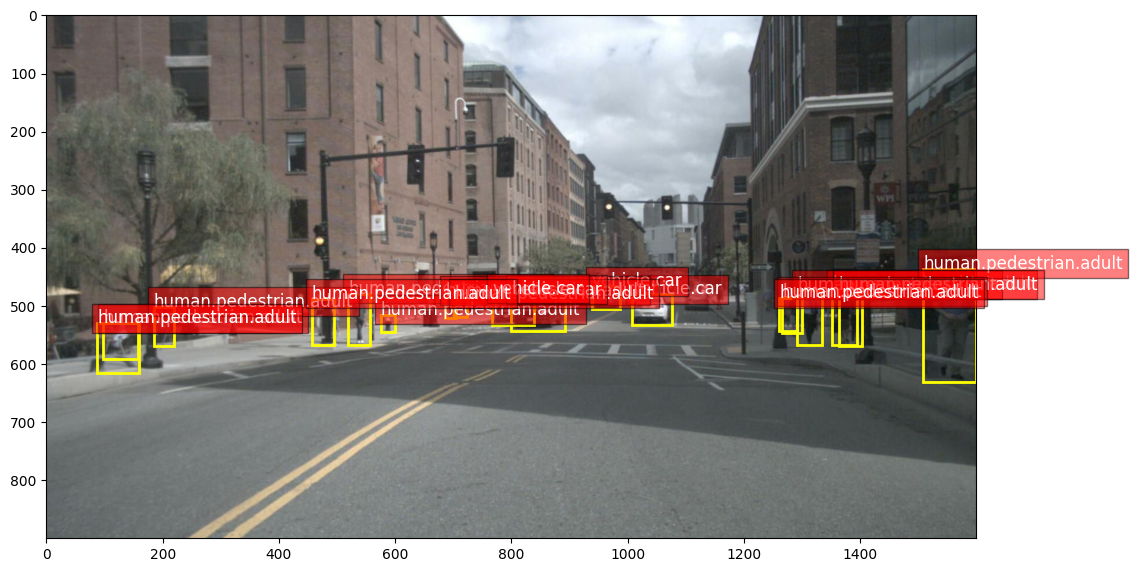

In [53]:
# Usando o json para plotar as boxes (saída do yolo)
print(json_content['ba01f58b926a472b9d146cb5a54e9a2e']['boxes'])
print(json_content['ba01f58b926a472b9d146cb5a54e9a2e']['labels'])
print("Boxes de saída do yolo")
plot_boxes_on_image('custom_train/images/val/n008-2018-08-01-15-16-36-0400__CAM_FRONT__1533151604012404.jpg', json_content['ba01f58b926a472b9d146cb5a54e9a2e']['boxes'], json_content['ba01f58b926a472b9d146cb5a54e9a2e']['labels'])


Boxes originais do nuscenes


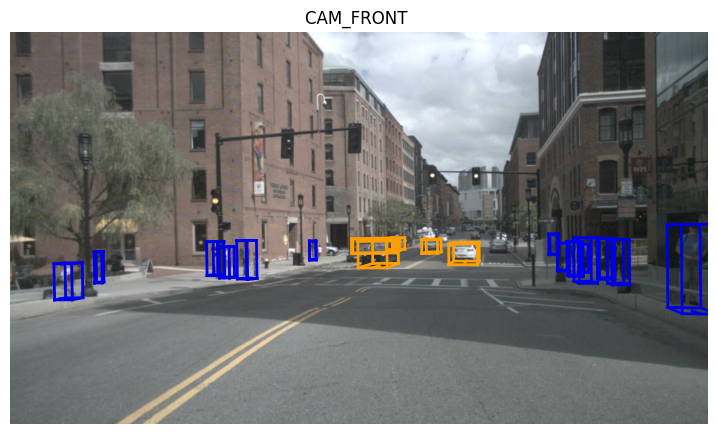

Boxes 2D do nuscenes


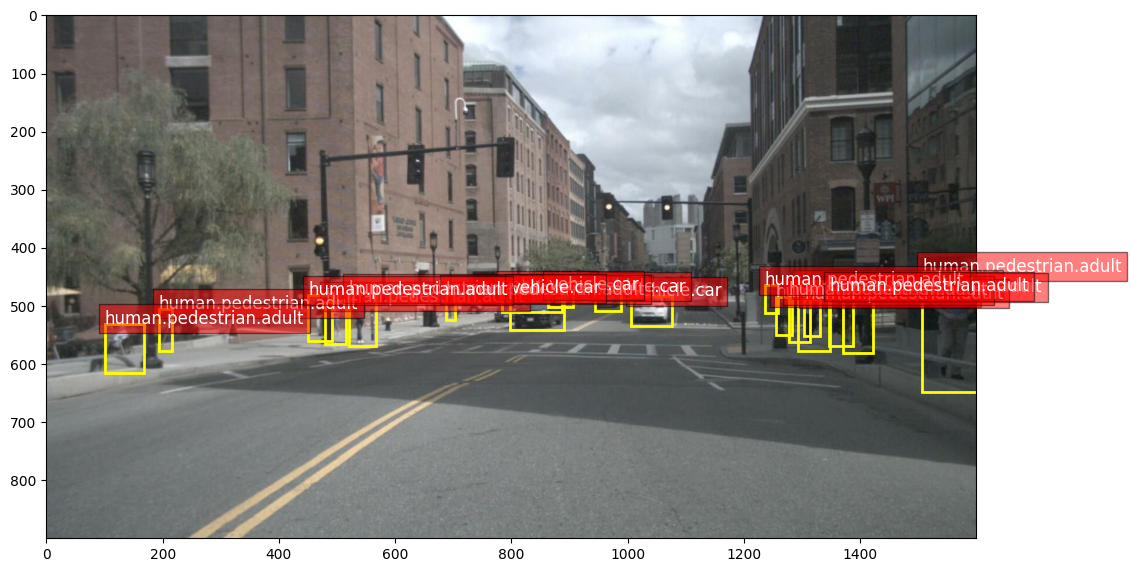

In [54]:
# Mostrando o frame direto da nuscenes
cena = nusc.get('sample', '3950bd41f74548429c0f7700ff3d8269')
print("Boxes originais do nuscenes")
nusc.render_sample_data(cena['data']['CAM_FRONT'])

sample = nusc.get('sample', '3950bd41f74548429c0f7700ff3d8269')
data = nusc.get('sample_data', sample['data']['CAM_FRONT'])
filename = data['filename']
boxes, anns = get_boxes_from_specified_frame(nusc, sample['token'])

print("Boxes 2D do nuscenes")
plot_boxes_on_image('data/sets/nuscenes/' + filename, boxes, anns)

#discover what is this token cc8c0bf57f984915a77078b10eb33198
scene = nusc.get('scene', 'cc8c0bf57f984915a77078b10eb33198')



[(1245.7866892853185, 475.34746781138864, 1267.3752896978735, 514.2613591929758), (1565.1104026754142, 488.6597179140922, 1694.2973419873185, 526.4010637661264), (1226.7018755315946, 475.59000645547866, 1273.3620227114468, 515.7308819823318), (1577.1906198398026, 477.48267535657646, 1619.9457222671742, 548.1815204433902), (778.0308304711076, 461.2120947464004, 795.0517880946078, 497.89553257692756), (691.9907985307514, 467.2883776765617, 712.186120264203, 505.16438428579295), (1271.9772390067585, 502.4480693723626, 1357.3036887315434, 581.4717048033152), (1238.0467400340822, 500.72142008555466, 1315.0447546886933, 571.0993991738932), (1034.668746089555, 469.4960365224752, 1129.2981400764827, 543.1676918123081), (1253.2520159984251, 478.3723419481723, 1278.0726656381973, 518.1694237622283), (-578.2813013349312, -38.94452824500709, 570.6019589187357, 844.8151952372851), (637.3313702985795, 451.0659965126782, 729.9389645284167, 491.64924277538495), (770.1870106750193, 457.04943177186095, 

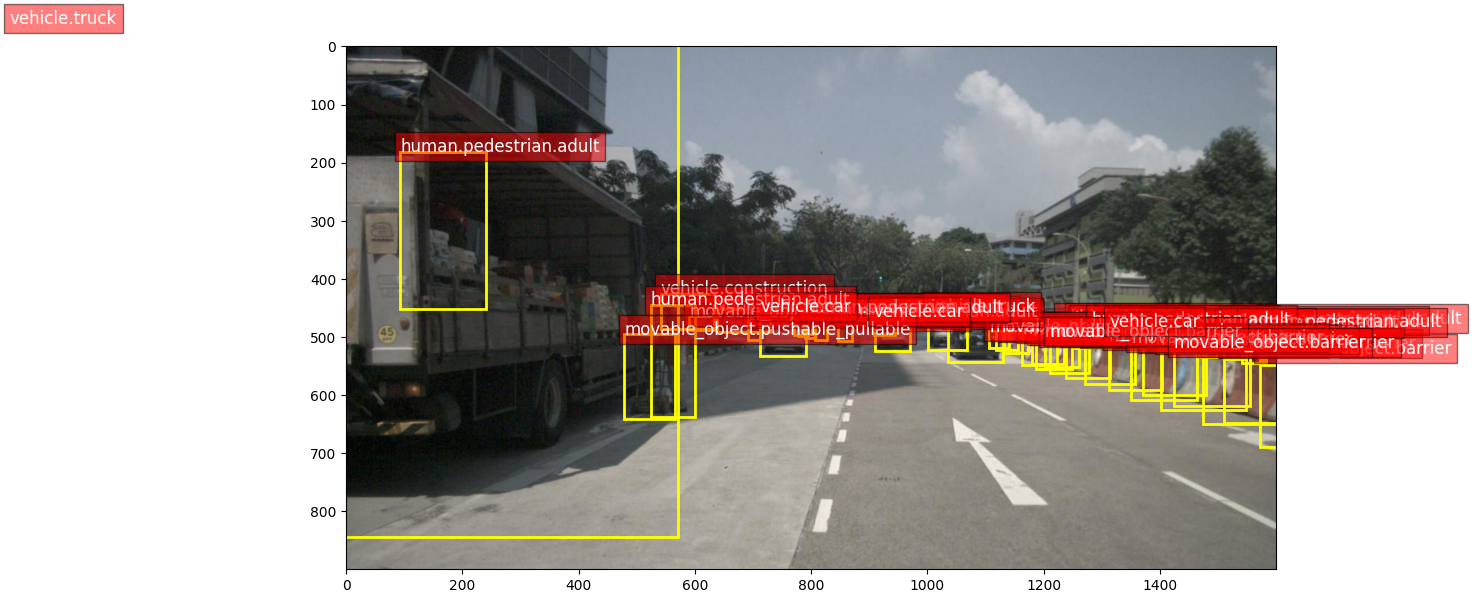

In [55]:
# Mostrando as boxes convertidas do nuscenes (usei um frame arbitrario aqui só pra demonstrar)
path = scenes_data['cc8c0bf57f984915a77078b10eb33198'][0]['path']
boxes = scenes_data['cc8c0bf57f984915a77078b10eb33198'][0]['boxes']
annotations = scenes_data['cc8c0bf57f984915a77078b10eb33198'][0]['anns']
print(boxes)
print(annotations)
plot_boxes_on_image(path, boxes, annotations)


